#### Poprawić
 * dane testowe - w test nie zamieniono datetime na taki format jaki był w train

In [13]:
import pandas as pd
import matplotlib as pl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor  
from sklearn.tree import DecisionTreeRegressor 
from sklearn.svm import LinearSVR
from sklearn import svm
import numpy as np

In [2]:
def rmsle(y_pred, y_true) :
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_true))**2))

### Import danych surowych
#### Podstawowa baza danych

In [3]:
data = pd.read_csv("bikes_train.csv")

data["datetime"] = pd.to_datetime(data["datetime"])
data["dayofweek"] = data["datetime"].dt.dayofweek      #The day of the week with Monday=0, Sunday=6
data["year"] = data["datetime"].dt.year
data["month"] = data["datetime"].dt.month
data["day"] = data["datetime"].dt.day
data["hour"] = data["datetime"].dt.hour
del data["datetime"] # usunięcie rozbitej kolumny

data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,dayofweek,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,5,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,5,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,5,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,5,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,5,2011,1,1,4


#### Wydzielenie zmiennych zależnych i features

In [4]:
features = ["season","holiday","workingday","weather","temp","atemp","humidity","windspeed","dayofweek","year","month","day","hour"]
X = data[features]

y_casual = data["casual"]
y_registered = data["registered"]

#### Podział zbioru uczącego na wewnętrzny zbiór uczący i testowy

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y_casual+y_registered, test_size=0.2, random_state=42)

### Utworzenie modeli z użyciem wewnętrznego zbioru danych
#### Liniowy SVM

In [6]:
#Cvals = list(map(lambda x: 2**x,range(-8,11)))
#Evals = list(map(lambda x: 2**x,range(-12,5)))
Cvals = list(map(lambda x: 2**x,range(-1,3)))
Evals = list(map(lambda x: 2**x,range(-5,0)))
SVRparameters = {"C":Cvals, "loss":["epsilon_insensitive","squared_epsilon_insensitive" ], "epsilon":Evals}
SVRegressor = GridSearchCV(estimator = LinearSVR(), param_grid = SVRparameters, return_train_score=True, n_jobs=4)
SVRegressor.fit(X = X_train, y = y_train)
SVRegressor.best_estimator_

LinearSVR(C=4, dual=True, epsilon=0.0625, fit_intercept=True,
     intercept_scaling=1.0, loss='squared_epsilon_insensitive',
     max_iter=1000, random_state=None, tol=0.0001, verbose=0)

In [7]:
y_pred = SVRegressor.predict(X_test)
rmsle(y_pred, y_test)

C:\Users\miser\AppData\Local\conda\conda\envs\isa\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


1.0614717266748996

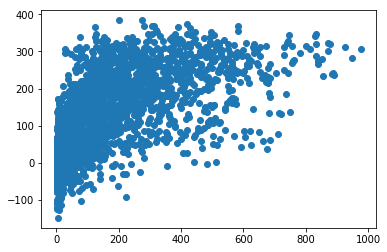

In [8]:
plt.scatter(y_test, y_pred)

#### Decision tree

In [9]:
DTparameters = {'max_depth': range(1, 11),
              'min_samples_split': range(2, 21), 'min_samples_leaf': range(1, 21)}
DTRegressor = GridSearchCV(estimator = DecisionTreeRegressor(), param_grid = DTparameters, n_jobs=4)
DTRegressor.fit(X = X_train, y=y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': range(1, 11), 'min_samples_split': range(2, 21), 'min_samples_leaf': range(1, 21)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [10]:
y_pred = DTRegressor.predict(X_test)
rmsle(y_pred, y_test)

0.3856016648118477

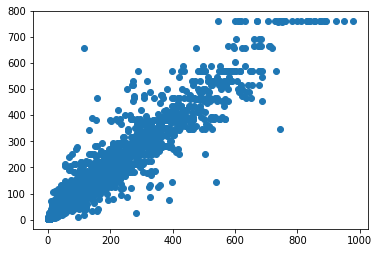

In [11]:
plt.scatter(y_test, y_pred)

#### Random forest

In [24]:
RFparameters = {"n_estimators":[100],  "bootstrap":[True, False], "criterion":["mse"]} 
RFRegressor = GridSearchCV(estimator=RandomForestRegressor(), param_grid=RFparameters, return_train_score=True, n_jobs=4)
RFRegressor.fit(X = X_train, y = y_train)
RFRegressor.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [26]:
y_pred = RFRegressor.predict(X_test)
rmsle(y_pred, y_test)

0.32999833376211796

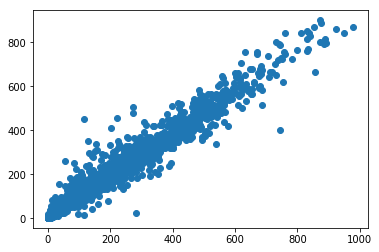

In [27]:
plt.scatter(y_test, y_pred)

In [ ]:
nfeat = len(X_train)
GVals = list(map(lambda x: 1/x,range(int(nfeat/2),2*nfeat)))
SVRparameters = {"C":Cvals, "epsilon":Evals,"gamma":GVals }
SVRegressor = GridSearchCV(estimator = svm.SVR(), param_grid = SVRparameters, return_train_score=True, n_jobs=4)
SVRegressor.fit(X = X_train, y = y_train)
SVRegressor.best_estimator_

In [ ]:
y_pred = SVRegressor.predict(X_test)
rmsle(y_pred, y_test)

In [ ]:
plt.scatter(y_test, y_pred)

In [ ]:
pd.DataFrame(y_pred).to_csv(path_or_buf="y_pred.csv")

### Decision tree

In [ ]:
predicted = regressor.predict(X_test)

In [ ]:
wyniki = pd.DataFrame({"y_true":y_test,"y_pred":predicted}, index = y_test.index)

In [ ]:
wyniki

In [ ]:
rmsle(y_pred=predicted, y_true=y_test)

In [ ]:
test = pd.read_csv("https://storage.googleapis.com/kaggle-competitions-data/kaggle/3948/test.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1528195692&Signature=j5Y0p3gSNPzLQ%2FlUG20AHX8D5YYcXqTJx%2FH6GoUoGzI1ECywxEhvRGlAjwe4V4B73NYHXLY0sYZPpSymKphoPF8as4eRNDrK%2BRu6gTC1mfYDRZoMp7%2F5fppYcQiWHtXJzTT3tZtt0q6SQZXrE5%2BHIFl2TNBnB7yTXrpG1Xif5upFEH6Ja7OLCCsmGlOmOhlI8RNm3uGMAgJhBGrnLojST%2FPCi4TeStZ2QqI4zYA3D4mGHSMGQzLw47tIP9CfOR1I14H53vc7MSLmzxMO7uhSd5h2uqVuDXzj%2B%2Br8HJjCjWpRve1dqhAWLrcW26SYZueG%2FKXXotm4UWvx6MD%2BCJzryg%3D%3D")
test.head()

In [ ]:
kaggle_test = test[["season","holiday","workingday","weather","temp","atemp","humidity","windspeed","dayofweek","year","month","day","hour"]]

In [ ]:
regressor.fit(X, y)

In [ ]:
test["count"] = regressor.predict(kaggle_test)

In [ ]:
test[["datetime", "count"]]

### Random Forest Regressor

In [ ]:
parameters = {"n_estimators":[100], 'max_features': np.arange(0.05, 1.01, 0.2), "bootstrap":[True, False], "criterion":["mse"]} 
forest = RandomForestRegressor()
regresor = GridSearchCV(estimator=forest, param_grid=parameters, return_train_score=True)

In [ ]:
regresor.fit(X=X_train, y=y_train)
regresor.best_estimator_

In [ ]:
prediction_rfc = regresor.predict(X_test)
prediction_rfc
results = pd.DataFrame({"y_true":y_test, "y_rfc": prediction_rfc})
rmsle(y_pred=prediction_rfc, y_true=y_test)
plt.scatter(y_test, prediction_rfc)

In [ ]:
test = pd.read_csv("https://storage.googleapis.com/kaggle-competitions-data/kaggle/3948/test.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1528195692&Signature=j5Y0p3gSNPzLQ%2FlUG20AHX8D5YYcXqTJx%2FH6GoUoGzI1ECywxEhvRGlAjwe4V4B73NYHXLY0sYZPpSymKphoPF8as4eRNDrK%2BRu6gTC1mfYDRZoMp7%2F5fppYcQiWHtXJzTT3tZtt0q6SQZXrE5%2BHIFl2TNBnB7yTXrpG1Xif5upFEH6Ja7OLCCsmGlOmOhlI8RNm3uGMAgJhBGrnLojST%2FPCi4TeStZ2QqI4zYA3D4mGHSMGQzLw47tIP9CfOR1I14H53vc7MSLmzxMO7uhSd5h2uqVuDXzj%2B%2Br8HJjCjWpRve1dqhAWLrcW26SYZueG%2FKXXotm4UWvx6MD%2BCJzryg%3D%3D")
test["datetime"] = pd.to_datetime(test["datetime"])
test["dayofweek"] = test["datetime"].dt.dayofweek      #The day of the week with Monday=0, Sunday=6
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
del test["datetime"]
test.head()